# **Imports**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import time
import random
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

# **Preprocessing**

In [ ]:
def preprocessing_features(df_train):
    """
    parse features column from long string to columns of features for every packet
    """
    first_drop = pd.DataFrame(df_train['feature'].str.split('['))
    x = pd.DataFrame(first_drop.feature.values.tolist()).add_prefix('feature_')
    x.drop('feature_0', axis=1, inplace=True)
    second_drop = pd.DataFrame(x['feature_1'].str.split(']'))
    x = pd.DataFrame(second_drop.feature_1.values.tolist()).add_prefix('feature_')
    x.drop('feature_1', axis=1, inplace=True)
    x = x.rename({'feature_0':'feature'}, axis=1)
    features = pd.DataFrame(x['feature'].str.split(','))
    x = pd.DataFrame(features.feature.values.tolist()).add_prefix('feature_')
    x = x.fillna(0)
    x = x.apply(np.float64)
    return x

In [ ]:
# get the data from csv

csvfile = pd.read_csv('/content/drive/MyDrive/combine.csv')
df = csvfile.sample(25000)

In [ ]:
print(df['app_label'].unique())

['12' '2' '15' '11' nan '13' '5' '16' '7' '3' '6' '1' '4' '9' '0' '8' '10'
 'app_label']


In [ ]:
#### todo - count the number of uniques with FM

In [ ]:
from torch.utils.data import Dataset

class PcapDataset(Dataset):
    def __init__(self, df_train):
      x = preprocessing_features(df_train)
      y = df_train['app_label']
      y = y.apply(np.float64)
      y.replace('0', 0, inplace=True)
      y.replace('1', 1, inplace=True)
      y.replace('2', 2, inplace=True)
      y.replace('3', 3, inplace=True)
      y.replace('4', 4, inplace=True)
      y.replace('5', 5, inplace=True)
      y.replace('6', 6, inplace=True)
      y.replace('7', 7, inplace=True)
      y.replace('8', 8, inplace=True)
      y.replace('9', 9, inplace=True)
      y.replace('10', 10, inplace=True)
      y.replace('11', 11, inplace=True)
      y.replace('12', 12, inplace=True)
      y.replace('13', 13, inplace=True)
      y.replace('15', 15, inplace=True)
      y.replace('16', 14, inplace=True)

      self.x_train = torch.tensor(x.values, dtype=torch.float64)
      self.y_train = torch.tensor(y.values, dtype=torch.float64)

    def __len__(self):
        return len(self.y_train)

    def __getitem__(self, idx):
        return self.x_train[idx], self.y_train[idx]

In [ ]:
# train-test split
df['split'] = np.random.randn(df.shape[0], 1)
msk = np.random.rand(len(df)) <= 0.8
train = df[msk]
test = df[~msk]
train.drop(columns=['split'], inplace=True)
test.drop(columns=['split'], inplace=True)
train.dropna(axis=0, how='any', inplace=True)
test.dropna(axis=0, how='any', inplace=True)

# load data
pcap_train = PcapDataset(train)
print(pcap_train.y_train.unique())
pcap_test = PcapDataset(test)
print(pcap_test.y_train.unique())

pcap_train.y_train[pcap_train.y_train==16] = 4
pcap_test.y_train[pcap_test.y_train==16] = 4
pcap_train.y_train[pcap_train.y_train==12] = 7
pcap_test.y_train[pcap_test.y_train==12] = 7
pcap_train.y_train[pcap_train.y_train==10] = 8
pcap_test.y_train[pcap_test.y_train==10] = 8

print(pcap_train.y_train.unique())
print(pcap_test.y_train.unique())

train_loader = torch.utils.data.DataLoader(pcap_train, batch_size=25, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(pcap_test, batch_size=25, shuffle=False, drop_last=True)

tensor([ 0.,  1.,  2.,  3.,  5.,  6.,  9., 10., 12., 16.], dtype=torch.float64)
tensor([ 0.,  1.,  2.,  3.,  5.,  6.,  9., 10., 12., 16.], dtype=torch.float64)
tensor([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.], dtype=torch.float64)
tensor([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.], dtype=torch.float64)


# **CNN - train and evaluate model on original data** (packets before sampling)

In [ ]:
class CNN(nn.Module):

  def __init__(self):
      super(CNN, self).__init__()
      self.conv1 = nn.Conv1d(1, 200, 5, 1, 0)
      self.conv2 = nn.Conv1d(200, 100, 5, 1, 0)

      self.dropout = nn.Dropout(p=0.05)

      self.fc1 = nn.Linear(37200, 10000)
      self.fc2 = nn.Linear(10000, 2000)
      self.fc3 = nn.Linear(2000, 500)
      self.fc4 = nn.Linear(500, 100)
      self.out = nn.Linear(100,10)

  def forward(self, x):
      x = F.avg_pool1d(F.relu(self.conv1(x)),2)
      x = self.dropout(x)
      x = F.avg_pool1d(F.relu(self.conv2(x)),2)
      x = self.dropout(x)

      x = torch.flatten(x, start_dim=1)
      x = F.relu(self.fc1(x))
      x = self.dropout(x)     
      x = F.relu(self.fc2(x))
      x = self.dropout(x)
      x = F.relu(self.fc3(x))
      x = self.dropout(x)
      x = F.relu(self.fc4(x))
      x = self.dropout(x)

      x = self.out(x)

      return x

In [ ]:
model = CNN().cuda()
print(model)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

CNN(
  (conv1): Conv1d(1, 200, kernel_size=(5,), stride=(1,))
  (conv2): Conv1d(200, 100, kernel_size=(5,), stride=(1,))
  (dropout): Dropout(p=0.05, inplace=False)
  (fc1): Linear(in_features=37200, out_features=10000, bias=True)
  (fc2): Linear(in_features=10000, out_features=2000, bias=True)
  (fc3): Linear(in_features=2000, out_features=500, bias=True)
  (fc4): Linear(in_features=500, out_features=100, bias=True)
  (out): Linear(in_features=100, out_features=10, bias=True)
)


In [ ]:
# Train the model
train_loss = []
interval_tuples = []
start = time.time()

for epoch in range(5):
    running_train_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        labels = labels.long()
        inputs = np.expand_dims(inputs, axis=1)
        inputs = torch.Tensor(inputs)
        inputs = inputs.cuda() # -- for GPU
        labels = labels.cuda() # -- for GPU
        
        # zero the parameters gradients
        optimizer.zero_grad()

        # forward + backward + optimization
        outputs = model(inputs)

        #print(outputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_train_loss += loss.item()
        if (i+1) % 100 == 0:
            interval_tuples.append(str((epoch + 1, i + 1)))
            print("[{}, {}] loss: {}".format(epoch + 1, i + 1, running_train_loss / 100))
            train_loss.append(running_train_loss / 100)
            running_train_loss = 0.0

stop = time.time()
original_time = stop - start
print("Training time: {}".format(original_time))

[1, 100] loss: 1.6967411267757415
[1, 200] loss: 1.0780961614847184
[1, 300] loss: 0.9364564970135689
[2, 100] loss: 0.7598067459464073
[2, 200] loss: 0.6995960634946823
[2, 300] loss: 0.571609861254692
[3, 100] loss: 0.45884710416197777
[3, 200] loss: 0.3646746177598834
[3, 300] loss: 0.3759223698452115
[4, 100] loss: 0.47412117034196855
[4, 200] loss: 0.3878405373543501
[4, 300] loss: 0.3362208106834441
[5, 100] loss: 0.25473055101931097
[5, 200] loss: 0.25973448319360615
[5, 300] loss: 0.26319152565672993
Training time: 586.8856654167175


In [ ]:
total = 0
correct = 0
with torch.no_grad(): 
    for data in test_loader:
        inputs, labels = data
        labels = labels.float()
        inputs = np.expand_dims(inputs, axis=1)
        inputs = torch.Tensor(inputs)
        inputs = inputs.cuda() # -- for GPU
        labels = labels.cuda() # -- for GPU

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
original_accuracy = (100 * correct / total)
print('Accuracy: {}%'.format(original_accuracy))

Accuracy: 93.4320987654321%


# **Packets' sampling experiments**

In [ ]:
def trimmed_packet(df, trimmed_length):
    # Systematic sampling - trimming the packet (first trimmed_length_bytes)
    return df[df.columns[0:trimmed_length]] 

def every_other_x_packet(df, x):
    # Systematic sampling - choosing every other xth element of the packet
    return df[df.columns[::x]]

def random_sampled_packet(df, sampled_length):
    # Random sampling (reservoir)
    i = 0
    r = np.zeros((df.shape[0],sampled_length))
    for i in range(df.shape[0]):
      for j in range(sampled_length):
          r[i,j] = df.iloc[i,j]
      for j in range(sampled_length,df.shape[1]):
          l = random.randrange(j + 1)
          if l < sampled_length:
              k = random.randrange(sampled_length)
              r[i,k] = df.iloc[i,k]
    return pd.DataFrame(r)

In [ ]:
df_train = pd.DataFrame(pcap_train.x_train.numpy())
df_test = pd.DataFrame(pcap_test.x_train.numpy())

In [ ]:
# 50%

random_train = random_sampled_packet(df_train, 750)
random_test = random_sampled_packet(df_test, 750)

trimmed_train = trimmed_packet(df_train, 750)
trimmed_test = trimmed_packet(df_test, 750)

everyother_train = every_other_x_packet(df_train, 2)
everyother_test = every_other_x_packet(df_test, 2)

In [ ]:
# 20%

random_train = random_sampled_packet(df_train, 300)
random_test = random_sampled_packet(df_test, 300)

trimmed_train = trimmed_packet(df_train, 300)
trimmed_test = trimmed_packet(df_test, 300)

everyother_train = every_other_x_packet(df_train, 5)
everyother_test = every_other_x_packet(df_test, 5)

In [ ]:
# 10%

random_train = random_sampled_packet(df_train, 150)
random_test = random_sampled_packet(df_test, 150)


trimmed_train = trimmed_packet(df_train, 150)
trimmed_test = trimmed_packet(df_test, 150)

everyother_train = every_other_x_packet(df_train, 10)
everyother_test = every_other_x_packet(df_test, 10)

KeyboardInterrupt: ignored

In [ ]:
# 5%

random_train = random_sampled_packet(df_train, 75)
random_test = random_sampled_packet(df_test, 75)

trimmed_train = trimmed_packet(df_train, 75)
trimmed_test = trimmed_packet(df_test, 75)

everyother_train = every_other_x_packet(df_train, 20)
everyother_test = every_other_x_packet(df_test, 20)

In [ ]:
# 3%

random_train = random_sampled_packet(df_train, 45)
random_test = random_sampled_packet(df_test, 45)

trimmed_train = trimmed_packet(df_train, 45)
trimmed_test = trimmed_packet(df_test, 45)

everyother_train = every_other_x_packet(df_train, 33)
everyother_test = every_other_x_packet(df_test, 33)

In [ ]:
# 1%

random_train = random_sampled_packet(df_train, 15)
random_test = random_sampled_packet(df_test, 15)

trimmed_train = trimmed_packet(df_train, 15)
trimmed_test = trimmed_packet(df_test, 15)

everyother_train = every_other_x_packet(df_train, 100)
everyother_test = every_other_x_packet(df_test, 100)

            0    1         2         3   ...        11   12   13   14
0     0.270588  0.0  0.003922  0.792157  ...  0.858824  0.0  0.0  0.0
1     0.270588  0.0  0.000000  0.572549  ...  0.000000  0.0  0.0  0.0
2     0.270588  0.0  0.000000  0.156863  ...  0.952941  0.0  0.0  0.0
3     0.270588  0.0  0.019608  0.431373  ...  0.690196  0.0  0.0  0.0
4     0.270588  0.0  0.101961  0.337255  ...  0.603922  0.0  0.0  0.0
...        ...  ...       ...       ...  ...       ...  ...  ...  ...
8337  0.270588  0.0  0.000000  0.196078  ...  0.984314  0.0  0.0  0.0
8338  0.270588  0.0  0.000000  0.964706  ...  0.000000  0.0  0.0  0.0
8339  0.270588  0.0  0.000000  0.286275  ...  0.066667  0.0  0.0  0.0
8340  0.270588  0.0  0.000000  0.572549  ...  0.000000  0.0  0.0  0.0
8341  0.270588  0.0  0.019608  0.431373  ...  0.796078  0.0  0.0  0.0

[8342 rows x 15 columns]


In [ ]:
random_train_tensor = torch.tensor(random_train.values)
random_test_tensor = torch.tensor(random_test.values)

trimmed_train_tensor = torch.tensor(trimmed_train.values)
trimmed_test_tensor = torch.tensor(trimmed_test.values)

everyother_train_tensor = torch.tensor(everyother_train.values)
everyother_test_tensor = torch.tensor(everyother_test.values)

In [ ]:
#pcap_train.x_train = random_train_tensor
#pcap_test.x_train = random_test_tensor

#pcap_train.x_train = trimmed_train_tensor
#pcap_test.x_train = trimmed_test_tensor

pcap_train.x_train = everyother_train_tensor
pcap_test.x_train = everyother_test_tensor

train_loader = torch.utils.data.DataLoader(pcap_train, batch_size=25, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(pcap_test, batch_size=25, shuffle=False, drop_last=True)

In [ ]:
class CNN(nn.Module):

  def __init__(self):
      super(CNN, self).__init__()
      self.conv1 = nn.Conv1d(1, 200, 5, 1, 0)
      self.conv2 = nn.Conv1d(200, 100, 5, 1, 0)

      self.dropout = nn.Dropout(p=0.05)

      self.fc1 = nn.Linear(100, 10000)
      self.fc2 = nn.Linear(10000, 2000)
      self.fc3 = nn.Linear(2000, 500)
      self.fc4 = nn.Linear(500, 100)
      self.out = nn.Linear(100,10)

  def forward(self, x):
      x = F.avg_pool1d(F.relu(self.conv1(x)),2)
      x = self.dropout(x)
      #x = F.avg_pool1d(F.relu(self.conv2(x)),2)
      x = F.relu(self.conv2(x))
      x = self.dropout(x)

      x = torch.flatten(x, start_dim=1)
      #print(x.shape)
      x = F.relu(self.fc1(x))
      x = self.dropout(x)     
      x = F.relu(self.fc2(x))
      x = self.dropout(x)
      x = F.relu(self.fc3(x))
      x = self.dropout(x)
      x = F.relu(self.fc4(x))
      x = self.dropout(x)

      x = self.out(x)

      return x

In [ ]:
model = CNN().cuda()
print(model)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

CNN(
  (conv1): Conv1d(1, 200, kernel_size=(5,), stride=(1,))
  (conv2): Conv1d(200, 100, kernel_size=(5,), stride=(1,))
  (dropout): Dropout(p=0.05, inplace=False)
  (fc1): Linear(in_features=100, out_features=10000, bias=True)
  (fc2): Linear(in_features=10000, out_features=2000, bias=True)
  (fc3): Linear(in_features=2000, out_features=500, bias=True)
  (fc4): Linear(in_features=500, out_features=100, bias=True)
  (out): Linear(in_features=100, out_features=10, bias=True)
)


In [ ]:
# Train the model
train_loss = []
interval_tuples = []
start = time.time()

for epoch in range(5):
    running_train_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        labels = labels.long()
        inputs = np.expand_dims(inputs, axis=1)
        inputs = torch.Tensor(inputs)
        inputs = inputs.cuda() # -- for GPU
        labels = labels.cuda() # -- for GPU
        
        # zero the parameters gradients
        optimizer.zero_grad()

        # forward + backward + optimization
        outputs = model(inputs)

        #print(outputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_train_loss += loss.item()
        if (i+1) % 100 == 0:
            interval_tuples.append(str((epoch + 1, i + 1)))
            print("[{}, {}] loss: {}".format(epoch + 1, i + 1, running_train_loss / 100))
            train_loss.append(running_train_loss / 100)
            running_train_loss = 0.0

stop = time.time()
print("Training time: {}".format(stop-start))

[1, 100] loss: 1.664492518901825
[1, 200] loss: 1.650209059715271
[1, 300] loss: 1.6121315360069275
[2, 100] loss: 1.6024015748500824
[2, 200] loss: 1.5802311897277832
[2, 300] loss: 1.5736321461200715
[3, 100] loss: 1.5405156755447387
[3, 200] loss: 1.5352309596538545
[3, 300] loss: 1.5504788064956665
[4, 100] loss: 1.5319498920440673
[4, 200] loss: 1.5262454664707183
[4, 300] loss: 1.5071083307266235
[5, 100] loss: 1.5172078561782838
[5, 200] loss: 1.5113618528842927
[5, 300] loss: 1.5157889759540557
Training time: 36.878968954086304


In [ ]:
total = 0
correct = 0
with torch.no_grad(): 
    for data in test_loader:
        inputs, labels = data
        labels = labels.float()
        inputs = np.expand_dims(inputs, axis=1)
        inputs = torch.Tensor(inputs)
        inputs = inputs.cuda() # -- for GPU
        labels = labels.cuda() # -- for GPU

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy: {}%'.format((100 * correct / total)))

Accuracy: 37.793103448275865%


**Results' plot**

Text(0, 0.5, 'Accuracy')

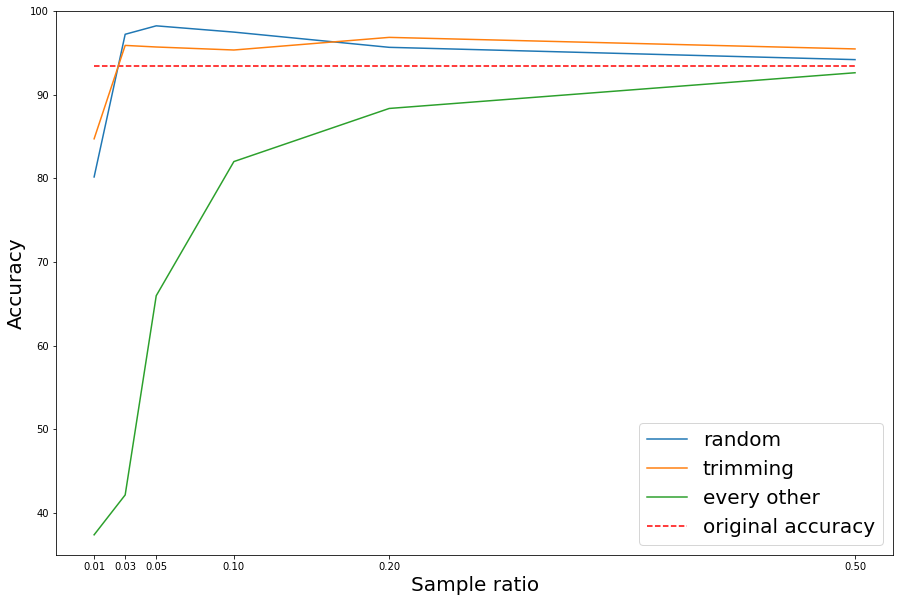

In [ ]:
plt.figure(figsize=[15,10])
plt.plot([0.01, 0.03, 0.05, 0.1, 0.2, 0.5], [80.18, 97.24, 98.25, 97.5, 95.68, 94.21],
         [0.01, 0.03, 0.05, 0.1, 0.2, 0.5], [84.74, 95.91, 95.72, 95.36, 96.87, 95.49],
         [0.01, 0.03, 0.05, 0.1, 0.2, 0.5], [37.39, 42.16, 65.98, 82.02, 88.37, 92.64])
plt.xticks([0.01, 0.03, 0.05, 0.1, 0.2, 0.5])
plt.hlines(93.47, 0.01, 0.5, linestyle='dashed', color='r')
plt.legend(['random', 'trimming', 'every other', 'original accuracy'], prop={'size': 20})
plt.ylim((35,100))
plt.xlabel('Sample ratio', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)

Text(0, 0.5, 'Training time')

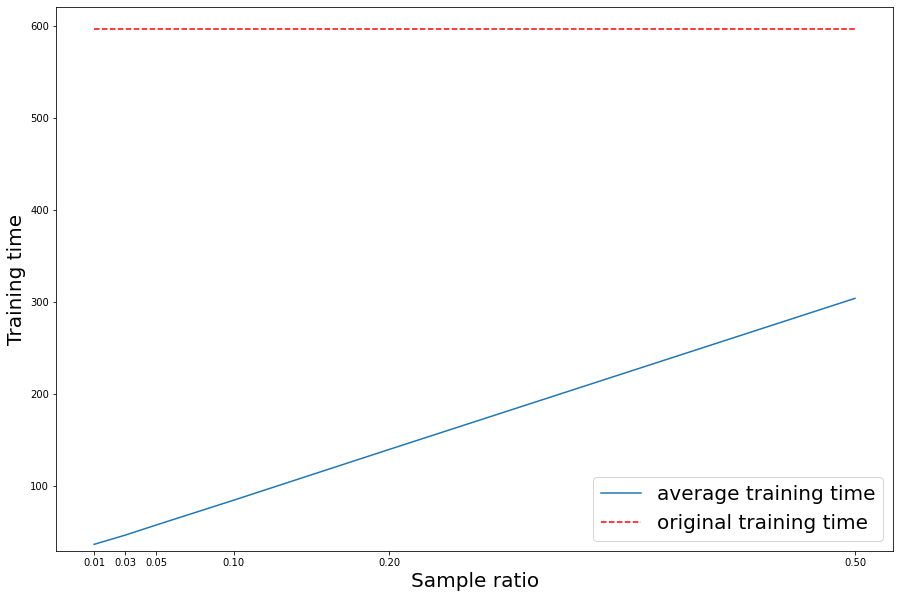

In [ ]:
plt.figure(figsize=[15,10])
plt.plot([0.01, 0.03, 0.05, 0.1, 0.2, 0.5], [37, 47, 58, 85, 140, 304])
plt.xticks([0.01, 0.03, 0.05, 0.1, 0.2, 0.5])
plt.ylim((30,620))
plt.hlines(596, 0.01, 0.5, linestyle='dashed', color='r')
plt.legend(['average training time', 'original training time'], prop={'size': 20}, loc='lower right')
plt.xlabel('Sample ratio', fontsize=20)
plt.ylabel('Training time', fontsize=20)

## **Dimensionality Reduction Experiments**

In [ ]:
class CNN_JL(nn.Module):

  def __init__(self, dim):
      super(CNN_JL, self).__init__()
      self.conv1 = nn.Conv1d(1, 200, 5, 1, 0)
      self.conv2 = nn.Conv1d(200, 100, 5, 1, 0)

      self.dropout = nn.Dropout(p=0.05)

      self.fc1 = nn.Linear(dim, 10000)
      self.fc2 = nn.Linear(10000, 2000)
      self.fc3 = nn.Linear(2000, 500)
      self.fc4 = nn.Linear(500, 100)
      self.out = nn.Linear(100,10)

  def forward(self, x):
      x = F.avg_pool1d(F.relu(self.conv1(x)),2)
      x = self.dropout(x)
      x = F.avg_pool1d(F.relu(self.conv2(x)),2)
    #   x = F.relu(self.conv2(x))
      x = self.dropout(x)

      x = torch.flatten(x, start_dim=1)
      x = F.relu(self.fc1(x))
      x = self.dropout(x)     
      x = F.relu(self.fc2(x))
      x = self.dropout(x)
      x = F.relu(self.fc3(x))
      x = self.dropout(x)
      x = F.relu(self.fc4(x))
      x = self.dropout(x)

      x = self.out(x)

      return x

In [ ]:
df_train = pd.DataFrame(pcap_train.x_train.numpy())
df_test = pd.DataFrame(pcap_test.x_train.numpy())

In [ ]:
from sklearn.random_projection import johnson_lindenstrauss_min_dim

# get list of components for each epsilon in range 0,1 to 0.9
components = []
for eps in list(np.linspace(0.1, 0.9, 9)):
    components.append(johnson_lindenstrauss_min_dim(1500,eps))
components = pd.Series(components)
components = components[components < 1500].sort_values(ascending=True)
components = list(components)
print(components)

[180, 195, 223, 270, 351, 498, 812]


In [ ]:
# Using Johnson-Lindenstrauss dimensionality reduction technique
acc_jl_list = []
from sklearn.random_projection import SparseRandomProjection
# train model and get predictions
for dim in components:
    # dimensionality reduction
    # create the transformation
    sp = SparseRandomProjection(n_components = dim)
    x_train_np = sp.fit_transform(df_train)
    x_train_pd = pd.DataFrame(x_train_np)

    # evaluate the model and update the list of accuracies
    x_test_np = sp.transform(df_test)
    x_test_pd = pd.DataFrame(x_test_np)

    print("{} dimensions after JL dimensionality reduction".format(dim))

    # build model
    model = CNN_JL(int(np.floor((np.floor((dim-4)/2)-4)/2)*100)).cuda()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    train_loss = []
    interval_tuples = []
    start = time.time()

    pcap_train.x_train = torch.tensor(x_train_pd.values)
    pcap_test.x_train = torch.tensor(x_test_pd.values)

    train_loader = torch.utils.data.DataLoader(pcap_train, batch_size=25, shuffle=True, drop_last=True)
    test_loader = torch.utils.data.DataLoader(pcap_test, batch_size=25, shuffle=False, drop_last=True)

    for epoch in range(5):                               # todo - change back to 5 when running
        running_train_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            labels = labels.long()
            inputs = np.expand_dims(inputs, axis=1)
            inputs = torch.Tensor(inputs)
            inputs = inputs.cuda() # -- for GPU
            labels = labels.cuda() # -- for GPU
            
            # zero the parameters gradients
            optimizer.zero_grad()

            # forward + backward + optimization
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_train_loss += loss.item()
            if (i+1) % 100 == 0:
                interval_tuples.append(str((epoch + 1, i + 1)))
                print("[{}, {}] loss: {}".format(epoch + 1, i + 1, running_train_loss / 100))
                train_loss.append(running_train_loss / 100)
                running_train_loss = 0.0

    stop = time.time()
    print("Training time: {}".format(stop-start))

    # test accuracy
    total = 0
    correct = 0
    with torch.no_grad(): 
        for data in test_loader:
            inputs, labels = data
            labels = labels.float()
            inputs = np.expand_dims(inputs, axis=1)
            inputs = torch.Tensor(inputs)
            inputs = inputs.cuda() # -- for GPU
            labels = labels.cuda() # -- for GPU

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = (100 * correct / total)
    acc_jl_list.append(accuracy)
    print('Accuracy: {}%'.format(accuracy))

180 dimensions after JL dimensionality reduction
[1, 100] loss: 1.7514568877220154
[1, 200] loss: 1.2308864986896515
[1, 300] loss: 1.0295799666643142
[2, 100] loss: 0.9231122583150864
[2, 200] loss: 0.9096909552812577
[2, 300] loss: 0.8597238513827324
[3, 100] loss: 0.8015600076317787
[3, 200] loss: 0.7666018930077553
[3, 300] loss: 0.7340525794029236
[4, 100] loss: 0.6551377701759339
[4, 200] loss: 0.6711338685452938
[4, 300] loss: 0.6478825956583023
[5, 100] loss: 0.5722953003644943
[5, 200] loss: 0.6008952955901623
[5, 300] loss: 0.5463512700796127
Training time: 51.85697793960571
Accuracy: 79.62352941176471%
195 dimensions after JL dimensionality reduction
[1, 100] loss: 1.9249365544319152
[1, 200] loss: 1.5444816172122955
[1, 300] loss: 1.2977855676412582
[2, 100] loss: 1.0772901010513305
[2, 200] loss: 1.0341978806257248
[2, 300] loss: 0.8943522915244102
[3, 100] loss: 0.8796272522211075
[3, 200] loss: 0.8535493567585946
[3, 300] loss: 0.8491699704527855
[4, 100] loss: 0.8312174

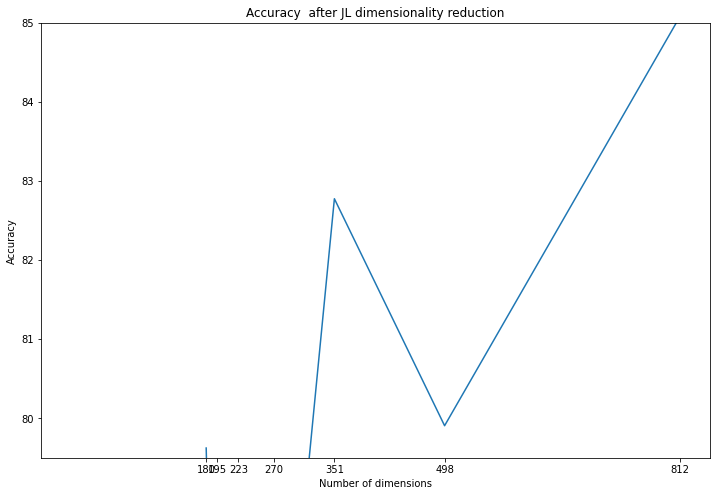

In [ ]:
# create the figure
plt.figure(figsize=[12,8])
plt.title("Accuracy  after JL dimensionality reduction")
plt.xticks(components)
plt.xlabel("Number of dimensions")
plt.ylabel("Accuracy")
plt.ylim((79.5,85))

# plot the baseline and random projection accuracies
plt.plot(components, acc_jl_list)
plt.hlines(93.47, 0.01, 0.5, linestyle='dashed', color='r')

In [ ]:
# dimensionality reduction with PCA

df_train = pd.DataFrame(pcap_train.x_train.numpy())
df_test = pd.DataFrame(pcap_test.x_train.numpy())

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
acc_pca_list = []
from sklearn.random_projection import SparseRandomProjection
# train model and get predictions
for dim in components:
    # dimensionality reduction
    # create the transformation
    pca = PCA(n_components = dim)
    x_train_np = pca.fit_transform(df_train)
    x_train_pd = pd.DataFrame(x_train_np)

    # evaluate the model and update the list of accuracies
    x_test_np = pca.transform(df_test)
    x_test_pd = pd.DataFrame(x_test_np)

    print("{} dimensions after PCA dimensionality reduction".format(dim))

    # build model
    model = CNN_JL(int(np.floor((np.floor((dim-4)/2)-4)/2)*100)).cuda()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    train_loss = []
    interval_tuples = []
    start = time.time()

    pcap_train.x_train = torch.tensor(x_train_pd.values)
    pcap_test.x_train = torch.tensor(x_test_pd.values)

    train_loader = torch.utils.data.DataLoader(pcap_train, batch_size=25, shuffle=True, drop_last=True)
    test_loader = torch.utils.data.DataLoader(pcap_test, batch_size=25, shuffle=False, drop_last=True)

    for epoch in range(5):
        running_train_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            labels = labels.long()
            inputs = np.expand_dims(inputs, axis=1)
            inputs = torch.Tensor(inputs)
            inputs = inputs.cuda() # -- for GPU
            labels = labels.cuda() # -- for GPU
            
            # zero the parameters gradients
            optimizer.zero_grad()

            # forward + backward + optimization
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_train_loss += loss.item()
            if (i+1) % 100 == 0:
                interval_tuples.append(str((epoch + 1, i + 1)))
                print("[{}, {}] loss: {}".format(epoch + 1, i + 1, running_train_loss / 100))
                train_loss.append(running_train_loss / 100)
                running_train_loss = 0.0

    stop = time.time()
    print("Training time: {}".format(stop-start))

    # test accuracy
    total = 0
    correct = 0
    with torch.no_grad(): 
        for data in test_loader:
            inputs, labels = data
            labels = labels.float()
            inputs = np.expand_dims(inputs, axis=1)
            inputs = torch.Tensor(inputs)
            inputs = inputs.cuda() # -- for GPU
            labels = labels.cuda() # -- for GPU

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = (100 * correct / total)
    acc_pca_list.append(accuracy)
    print('Accuracy: {}%'.format(accuracy))

180 dimensions after PCA dimensionality reduction


In [ ]:
# create the figure
plt.figure(figsize=[12,8])
plt.title("Accuracy after PCA dimensionality reduction")
plt.xlabel("Number of dimensions")
plt.ylabel("Accuracy")
# plt.ylim((79.5,85))

# plot the baseline and random projection accuracies
plt.plot(components, acc_pca_list)
plt.plot(components, acc_jl_list)
plt.legend()
plt.hlines(93.47, 0.01, 0.5, linestyle='dashed', color='r')